# Animations
In this notebook, we create animations of the particles in 2D and 3D space

In [1]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [15]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import matplotlib.gridspec as gridspec
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from matplotlib.animation import FuncAnimation, writers, PillowWriter, FFMpegWriter
from copy import copy
from glob import glob
from datetime import timedelta
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

In [3]:
datadir = '/data/oceanparcels/output_data/data_Reint/'#'/scratch/rfischer/Kooi_data/data_output/'
regions = {'EqPac': 'Equatorial Pacific',
           'GPGP': 'Great Pacific Garbage Patch',
           'SO': 'Southern Ocean',
           'NPSG': 'North Pacific Subtropical Gyre'}

In [4]:
r_pl_clist = ['#7a0177','#c51b8a','#f768a1', '#fbb4b9']
r_pl_cmap = plt.get_cmap('RdPu_r')

In [42]:
region = 'EqPac'
mortality = 0.39              # [d-1]
runtime = 458                  # [days]
dt = 60                       # [seconds]
outputdt = 12                  # [hours]
death = 'MEDUSA'
grazing = 'full'
mixing = 'markov_0_KPP_ceiling_tides_'+death
diss = 0.006
rho_p = 920
rho_bf = 1388
rho_fr= 1800
sizebinedges = [1e-3, 1e-4, 1e-5]
res = '1x1'
proc = 'bfadv'
season = 'Oct'
season_string = {'Jan':'January - July', 'MAM':'March - September', 'JJA':'June - December', 'SON':'September - March','DJF':'December - June'}

In [43]:
ds = xr.open_dataset(datadir+'regional_'+region+'_'+proc+'_'+season+'_2003_'+res+'res_'+mixing+'_'+str(rho_bf)+'rhobf_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')

In [44]:
number_of_trajectories_to_plot = 3
n_plt = number_of_trajectories_to_plot
f_plt = int(np.round(len(ds['traj'])/n_plt))
print('plotting '+str(n_plt)+' of '+str(len(ds['traj']))+' trajectories')
print('plotting every '+str(f_plt)+' particles')

plotting 3 of 10000 trajectories
plotting every 3333 particles


In [45]:
sizes = copy(ds['r_pl'][:].values)
ids = np.argsort(sizes)[::-1]
sizes = sizes[ids]
lons = copy(ds['lon'][:].values)[ids]
lats = copy(ds['lat'][:].values)[ids]
depths = copy(ds['z'][:].values)[ids]
algae = copy(ds['d_phy'][:].values)[ids]
sizecolors = (np.log10(sizes)-np.log10(sizes.min()))*256/(np.log10(sizes.max())-np.log10(sizes.min()))
times = copy(ds['time'][:].values)[ids]
sqrtsizes = np.sqrt(sizes)
c= r_pl_cmap(sizecolors.astype(int))

In [46]:
outputdt = np.timedelta64(12,'h')

timerange = np.arange(np.nanmin(times),
                      np.nanmax(times)+outputdt, #+outputdt.seconds, #
                      outputdt) #  # timerange in nanoseconds\n",

timedays = np.zeros(len(timerange), dtype='<U10')
for i in range(len(timerange)):
    timedays[i] = str(timerange[i])[:10]
timedays = np.unique(timedays)

In [47]:
time_id = np.where(np.logical_and(ds['time'] >= timerange[0],ds['time'] < timerange[1])) # All trajectory data for a single day

## Diatom concentration background

In [48]:
def getclosest_ij(lats,lons,latpt,lonpt):
    """Function to find the index of the closest point to a certain lon/lat value."""
    dist_sq = (lats-latpt)**2 + (lons-lonpt)**2                 # find squared distance of every point on grid
    minindex_flattened = dist_sq.argmin()                       # 1D index of minimum dist_sq element
    return np.unravel_index(minindex_flattened, lats.shape)     # Get 2D index for latvals and lonvals arrays from 1D index

#### Select diatom files

In [49]:
dirread = '/data/oceanparcels/input_data/NEMO-MEDUSA_BGC/ORCA0083-N006/means/'
yr = ['2003','2004','2005']
bgcfiles = sorted(glob(dirread+'*'+yr[0]+'*P.nc'))+sorted(glob(dirread+'*'+yr[1]+'*P.nc'))+sorted(glob(dirread+'*'+yr[2]+'*P.nc'))
mesh_mask = xr.open_dataset('/data/oceanparcels/input_data/NEMO-MEDUSA/ORCA0083-N006/domain/coordinates.nc', decode_times=False)
ds_bgc = xr.open_dataset(bgcfiles[0])
fielddepths= ds_bgc['deptht'][:20]

# --- Domain ----
xmin = 100
xmax = -60
ymin = -20
ymax = 20

jmin, imin = getclosest_ij(mesh_mask['glamf'][0].values,mesh_mask['gphif'][0].values,xmin,ymin)
jmax, imax = getclosest_ij(mesh_mask['glamf'][0].values,mesh_mask['gphif'][0].values,xmax,ymax)

#### Create diatom array

In [50]:
begin_nr = 14
end_nr = 114

diatoms = np.zeros((len(bgcfiles[begin_nr:end_nr]),ds_bgc['PHD'][0, 0, jmin:jmax-1, imin:imax-1].shape[0],ds_bgc['PHD'][0, 0, jmin:jmax-1, imin:imax-1].shape[1]))
time = np.zeros(len(bgcfiles[begin_nr:end_nr]),dtype='datetime64[ns]')

In [51]:
for i, filename in enumerate(bgcfiles[begin_nr:end_nr]):
    ds_b = xr.open_dataset(filename)
    diatoms[i] = np.nan_to_num(ds_b['PHD'][0, 0, jmin:jmax-1, imin:imax-1])
    time[i] = ds_b['time_counter'].values[0]

In [52]:
time_ns = (time-time[0]).astype(float)
timerange_ns = (timerange-time[0]).astype(float)


f = interp1d(time_ns,diatoms,axis=0)

### PlateCarree Equatorial Pacific 2D advection + depth in color

<IPython.core.display.Javascript object>


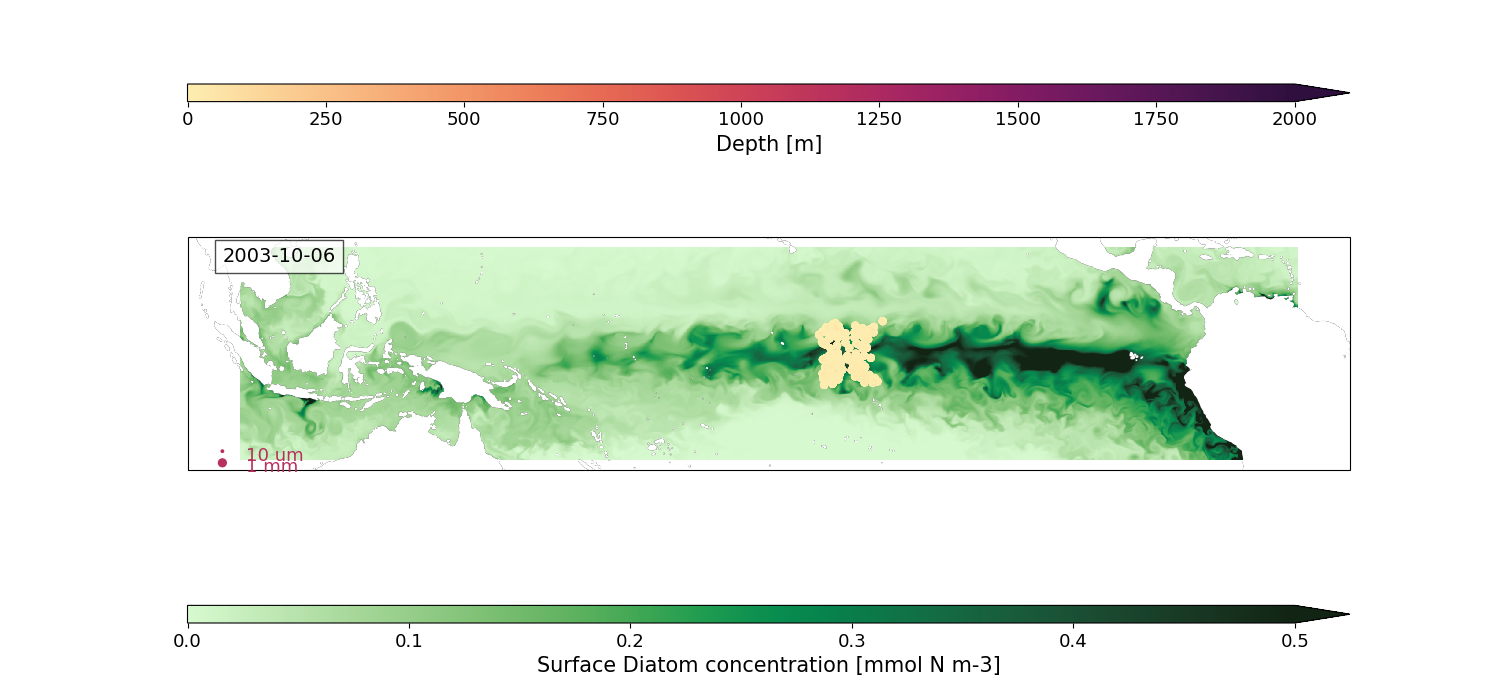

In [68]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 25, 1])

axcb0 = plt.subplot(gs[0])
axcb1 = plt.subplot(gs[2])
ax = plt.subplot(gs[1],projection=ccrs.PlateCarree(180))

diatoms_t = f(timerange_ns[0])
pc = ax.pcolormesh(mesh_mask['glamf'][0,jmin:jmax,imin:imax],mesh_mask['gphif'][0,jmin:jmax,imin:imax],diatoms_t, cmap='cmo.algae', vmax=0.5, zorder=1, transform=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.LAND, color='w',zorder=2)

ax.scatter([0.03,0.03],[0.03,0.08],color=plt.get_cmap('cmo.matter')(150),s=[np.max(sqrtsizes)*1000,np.min(sqrtsizes)*1000], zorder=5, transform=ax.transAxes)

size_text0 = ax.text(0.05, 0.05,'1 mm',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=13, color=plt.get_cmap('cmo.matter')(150)) # Initialise time ticker
size_text1 = ax.text(0.05, 0.1,'10 um',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=13, color=plt.get_cmap('cmo.matter')(150)) # Initialise time ticker

time_id = np.where(np.logical_and(times >= timerange[0],times < timerange[1])) # All trajectory data for a single day

vmax=2000
scatter = ax.scatter(lons[time_id].T,lats[time_id].T,c=depths[time_id].T,cmap='cmo.matter',marker='o',s=sqrtsizes*1000,linewidths=0.3, transform=ccrs.PlateCarree(),zorder=4,vmin=0,vmax=vmax)


time_text = ax.text(0.03, 0.96,'time',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'alpha':0.7, 'pad':5}, zorder=3) # Initialise time ticker

## Depth colorbar
CB0 = plt.colorbar(scatter, cax=axcb0,extend='max', orientation='horizontal')
CB0.set_label('Depth [m]', fontsize=15)
axcb0.tick_params(labelsize=13)

## Algae colorbar
CB1 = plt.colorbar(pc, cax=axcb1,extend='max', orientation='horizontal')
CB1.set_label('Surface Diatom concentration [mmol N m-3]', fontsize=15)
axcb1.tick_params(labelsize=13)

def animate(i):
    time_id = np.where(np.logical_and(times >= timerange[i],times < timerange[i+1]))
    scatter.set_offsets(np.c_[lons[time_id].T, lats[time_id].T])
    scatter.set_array(depths[time_id].T)
    
    diatoms_t = f(timerange_ns[i])
    pc.set_array(diatoms_t.ravel())
        
    if i%2==0:
        time_text.set_text(timedays[int(i/2)])  # Update the time
        
    return time_text, scatter, pc,


anim = FuncAnimation(fig, animate, frames = len(timerange)-10, interval=100, blit=True, repeat=True)

# writergif = PillowWriter(fps=20, codec="libx264")
# anim.save(region+'.gif', writer=writergif)

plt.show()

## Global Equatorial Pacific

<IPython.core.display.Javascript object>


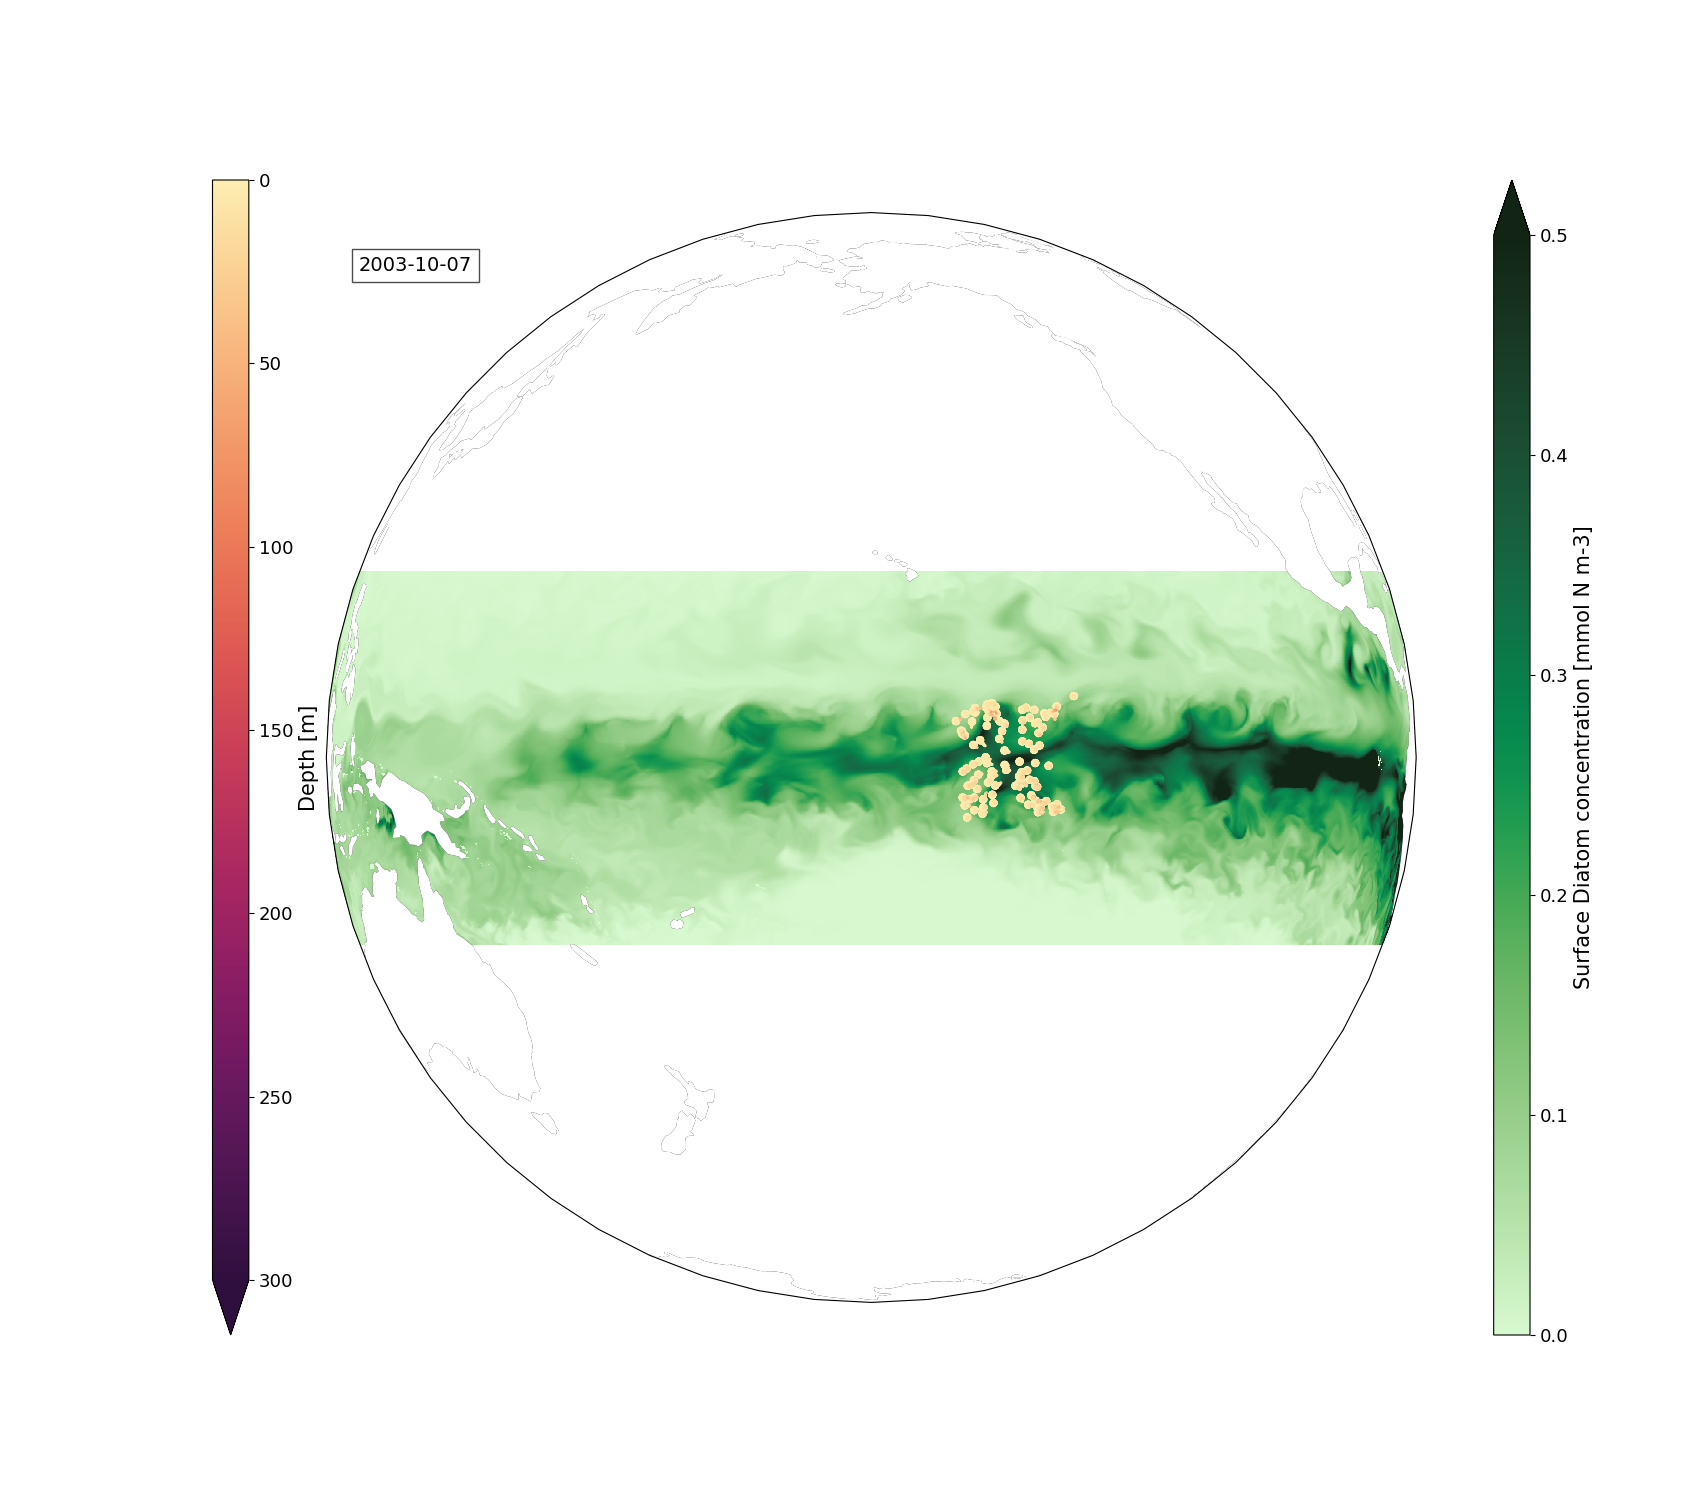

In [64]:
fig = plt.figure(figsize=(17,15))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 30, 1])

axcb0 = plt.subplot(gs[0])
axcb1 = plt.subplot(gs[2])
ax = plt.subplot(gs[1],projection=ccrs.Orthographic(central_longitude=-160))
ax.set_global()

diatoms_t = f(timerange_ns[0])
pc = ax.pcolormesh(mesh_mask['glamf'][0,jmin:jmax,imin:imax],mesh_mask['gphif'][0,jmin:jmax,imin:imax],diatoms_t, cmap='cmo.algae', vmax=0.5, zorder=1, transform=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.LAND, color='w',zorder=2)

time_id = np.where(np.logical_and(times >= timerange[0],times < timerange[1])) # All trajectory data for a single day

vmax=300
scatter = ax.scatter(lons[time_id].T,lats[time_id].T,c=depths[time_id].T,cmap='cmo.matter',marker='o',s=sqrtsizes*1000,linewidths=0.3, transform=ccrs.PlateCarree(),zorder=4,vmin=0,vmax=vmax)

time_text = ax.text(0.03, 0.96,'time',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'alpha':0.7, 'pad':5}, zorder=3) # Initialise time ticker

## Depth colorbar
CB0 = plt.colorbar(scatter, cax=axcb0,extend='max')
CB0.set_label('Depth [m]', fontsize=15)
axcb0.tick_params(labelsize=13)
axcb0.invert_yaxis()

## Algae colorbar
CB1 = plt.colorbar(pc, cax=axcb1,extend='max')
CB1.set_label('Surface Diatom concentration [mmol N m-3]', fontsize=15)
axcb1.tick_params(labelsize=13)

def animate(i):
    time_id = np.where(np.logical_and(times >= timerange[i],times < timerange[i+1]))
    scatter.set_offsets(np.c_[lons[time_id].T, lats[time_id].T])
    scatter.set_array(depths[time_id].T)
    
    diatoms_t = f(timerange_ns[i])
    pc.set_array(diatoms_t.ravel())
        
    if i%2==0:
        time_text.set_text(timedays[int(i/2)])  # Update the time
        
    return scatter, pc, time_text,


anim = FuncAnimation(fig, animate, frames = len(timerange)-10, interval=100, blit=True, repeat=True)

# writergif = PillowWriter(fps=20, codec="libx264")
# anim.save(region+'.gif', writer=writergif)

plt.show()

## Global Southern Ocean

<IPython.core.display.Javascript object>


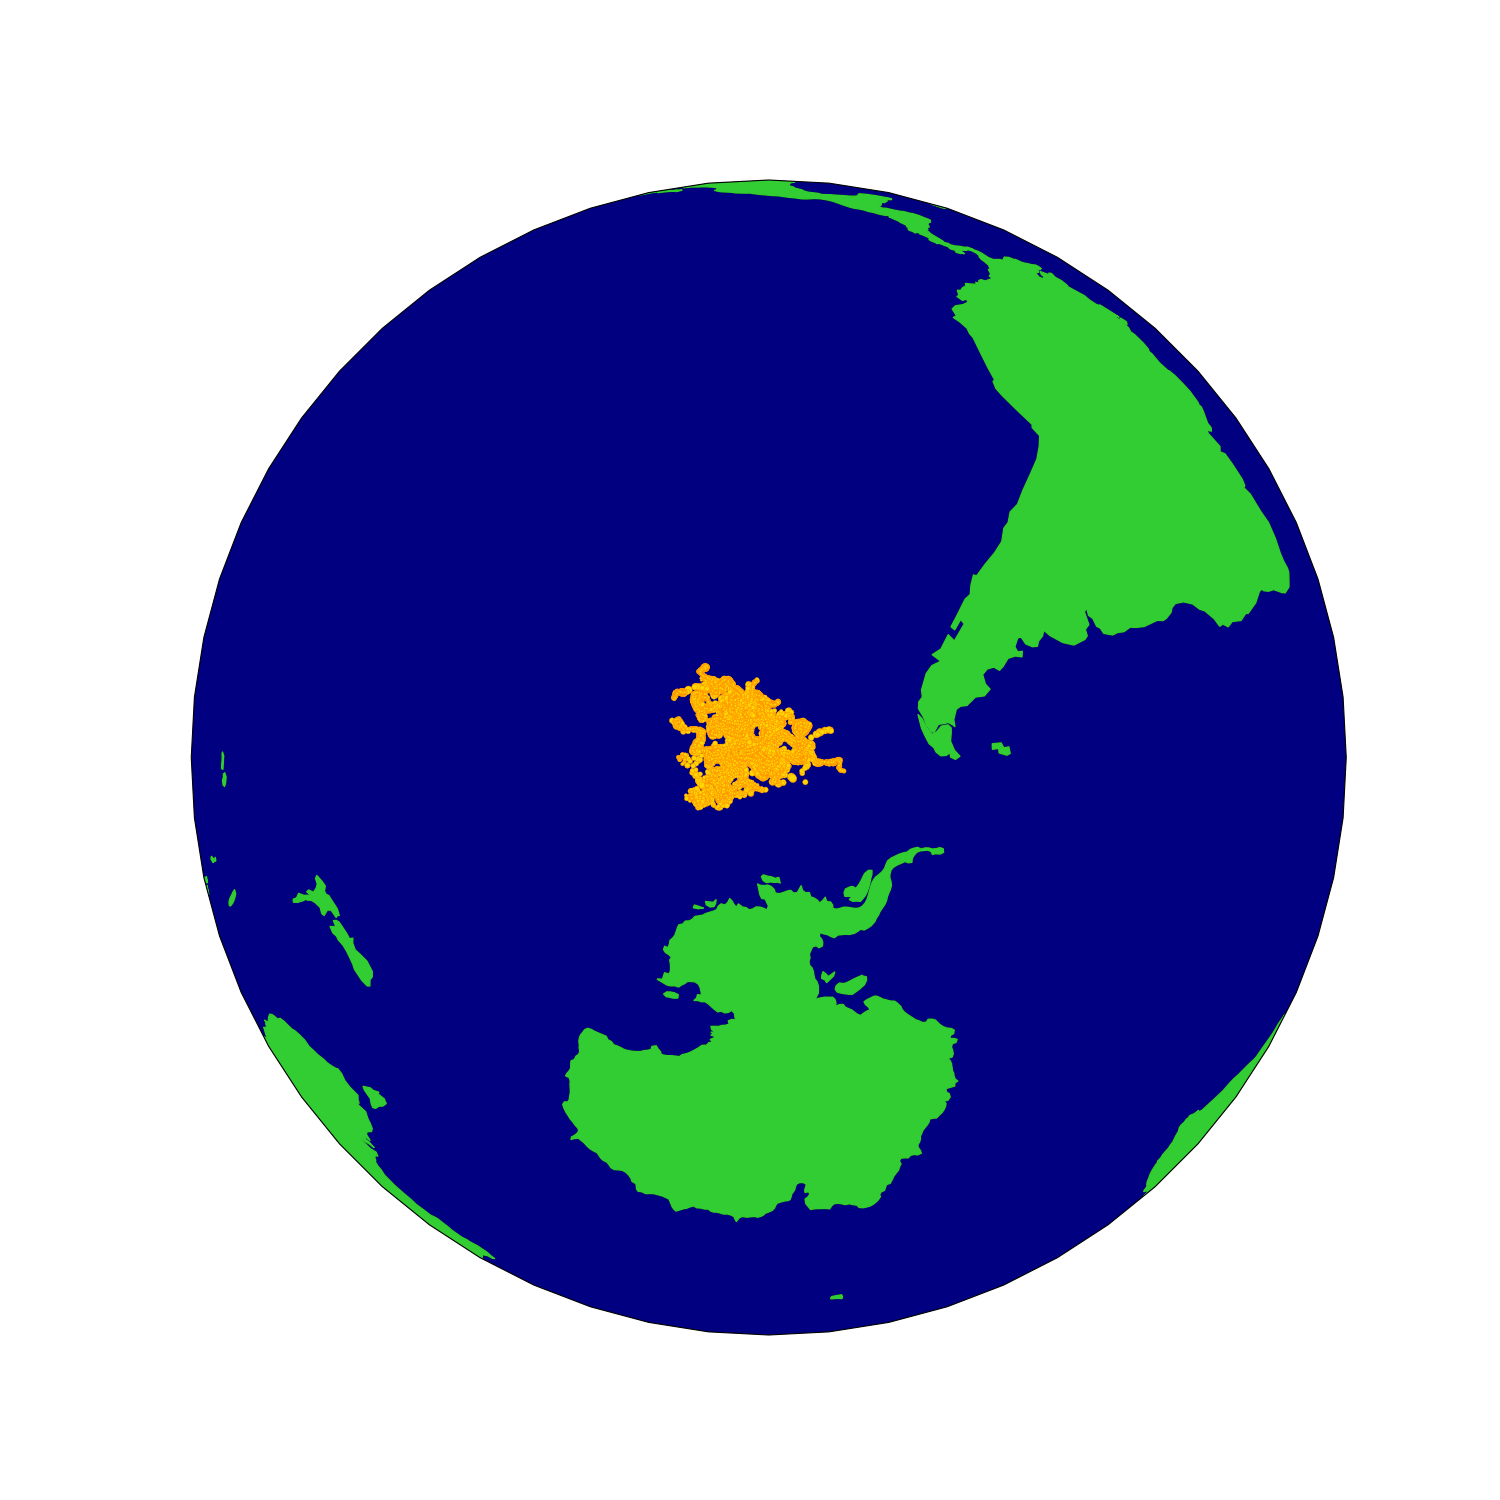

In [18]:
fig = plt.figure(figsize=(15,15))
# gs = gridspec.GridSpec(3, 1, height_ratios=[1, 18, 1])

# axcb0 = plt.subplot(gs[0])
# axcb1 = plt.subplot(gs[2])
# ax = plt.subplot(gs[1],projection=ccrs.Orthographic(central_longitude=180))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-100, central_latitude=-60))
ax.set_global()
# pc = ax.pcolormesh(mesh_mask['glamf'][0,jmin:jmax,imin:imax],mesh_mask['gphif'][0,jmin:jmax,imin:imax],diatoms[0,0], cmap='cmo.algae', vmax=0.5, zorder=1, transform=ccrs.PlateCarree())
ax.set_facecolor('navy')
ax.coastlines()
ax.add_feature(cfeature.LAND, color='limegreen',zorder=2)

# ax.scatter([0.03,0.03],[0.03,0.08],color=plt.get_cmap('cmo.matter')(150),s=[np.max(sqrtsizes)*1000,np.min(sqrtsizes)*1000], zorder=5, transform=ax.transAxes)

# size_text0 = ax.text(0.05, 0.05,'1 mm',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=13, color=plt.get_cmap('cmo.matter')(150)) # Initialise time ticker
# size_text1 = ax.text(0.05, 0.1,'10 um',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=13, color=plt.get_cmap('cmo.matter')(150)) # Initialise time ticker

time_id = np.where(np.logical_and(times >= timerange[0],times < timerange[1])) # All trajectory data for a single day

vmax=1000
scatter = ax.scatter(lons[time_id].T,lats[time_id].T,marker='o',s=sqrtsizes*1000,linewidths=0.3, transform=ccrs.PlateCarree(),zorder=4,color='gold', edgecolor='darkorange')#c=depths[time_id].T,cmap='cmo.matter',vmin=0,vmax=vmax)


# time_text = ax.text(0.03, 0.96,'time',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'alpha':0.7, 'pad':5}, zorder=3) # Initialise time ticker

# ## Depth colorbar
# CB0 = plt.colorbar(scatter, cax=axcb0,extend='max', orientation='horizontal')
# CB0.set_label('Depth [m]', fontsize=15)
# axcb0.tick_params(labelsize=13)

# ## Algae colorbar
# CB1 = plt.colorbar(pc, cax=axcb1,extend='max', orientation='horizontal')
# CB1.set_label('Surface Diatom concentration [mmol N m-3]', fontsize=15)
# axcb1.tick_params(labelsize=13)

def animate(i):
    time_id = np.where(np.logical_and(times >= timerange[i],times < timerange[i+1]))
    scatter.set_offsets(np.c_[lons[time_id].T, lats[time_id].T])
#     scatter.set_array(depths[time_id].T)
    
#     if i%10==0:
#         pc.set_array(diatoms[int(i/10),int(i%10)].ravel())
        
#     if i%2==0:
#         time_text.set_text(timedays[int(i/2)])  # Update the time
        
    return scatter,# pc, #time_text,


anim = FuncAnimation(fig, animate, frames = len(timerange)-10, interval=100, blit=True, repeat=True)

# writergif = PillowWriter(fps=20, codec="libx264")
# anim.save(region+'.gif', writer=writergif)

plt.show()